# **Water Quality**

**The Problem: Can we predict which water samples are Potable or Non-Potable?**

I've had a hiatus from Kaggle and this dataset is a nice way to try and get back in to the swing of things.

An additional goal of this notebook was to demonstrate DataFrame styling.

This is a useful tool as one can quickly highlight areas of importance in a dataframe, for example by highlighting max values etc.


**Disclaimer**: 

There has been a fair amount of discussion in relation to this dataset centred on the idea that it is not genuine. 
Through this analysis, it was very difficult to separate the two classes (Potable & Non-Potable), and of the classifications didn't make a lot of sense given the value of other variables. 

Having said that, I have decided to publish this notebook nontheless, as I feel that some of the methods and snippets of code might still be useful for some, even if the conclusions aren't of real-world value!



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Extra Libs
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, auc, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

# Default visual settings

plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 150
background_color='#F5F4EF'


#sns.palplot(["#fbfbfb","#f5f4ef", "#4b4b4c","#8abbd0","#0e4f66","#244747"])

# Ignore warnings

import warnings
warnings.filterwarnings("ignore")

# Print colored text 
# https://stackoverflow.com/questions/287871/how-to-print-colored-text-to-the-terminal
# Includes other color options

HEADER = '\033[95m'
OKBLUE = '\033[94m'
OKCYAN = '\033[96m'
OKGREEN = '\033[92m'
WARNING = '\033[93m'
FAIL = '\033[91m'
ENDC = '\033[0m'
BOLD = '\033[1m'
UNDERLINE = '\033[4m'

class color:
    S = BOLD + OKBLUE +  UNDERLINE   #S = Start
    E = ENDC #E = End

print(color.S+"Libraries loaded"+color.E)

/kaggle/input/water-potability/water_potability.csv
Libraries loaded


# **The Data**

In [2]:
df = pd.read_csv('/kaggle/input/water-potability/water_potability.csv')

# Show first n rows of data, default is 5
df.head(3).style.set_caption('Water Quality Dataset').hide_index().format(None,na_rep="Not Provided")

# Our 'y' (what we want to predict) is the 'Potability' column

# Data Checks & Cleaning

Typically before starting any project it is wise to **view & assess the datasets** you are provided. Today is no different.

A checklist of areas I like to initially view are:

* Data shape, i.e. Number of Rows & Columns
* Data types, i.e. Are all columns integers? Or text? etc.
* Missing data, i.e. Null Values
* Column names


In [3]:
def overview(df):
    print(color.S+'DataFrame Overview\n'+color.E)
    print('DataFrame Shape: \n',df.shape[0], 'Rows\n',df.shape[1],' Columns\n')
    print('Column Headers: \n',list(df.columns),'\n')
    print('Missing Values: \n',df.isnull().sum()/len(df))
    print('\nData Types:\n',df.dtypes)

In [4]:
overview(df)

DataFrame Overview

DataFrame Shape: 
 3276 Rows
 10  Columns

Column Headers: 
 ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'] 

Missing Values: 
 ph                 0.149878
Hardness           0.000000
Solids             0.000000
Chloramines        0.000000
Sulfate            0.238400
Conductivity       0.000000
Organic_carbon     0.000000
Trihalomethanes    0.049451
Turbidity          0.000000
Potability         0.000000
dtype: float64

Data Types:
 ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object


In [5]:
# We can also view if there is a diff in missing values based on our target variable
#print("Missing Values by Target Variable Class\n")
#print("Potability == 1\n")
#print(df.query("Potability == 1").isnull().sum()/len(df.query("Potability == 1")))

#print("\nPotability == 0\n")
#print(df.query("Potability == 0").isnull().sum()/len(df.query("Potability == 0")))

In [6]:
# Isolate columns that req changing
null_cols = []
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(col)
        null_cols.append(col)
        
# Assigned to list so can check later

ph
Sulfate
Trihalomethanes


# **Next Tasks** 

**Exploratory Data Analysis**

This will help us to understand the data. Are there interesting relationships between variables? Do some variables appear to be a good indiciator for what our target variable will be? 

**Next, let's split our data into Training & Test sets**

An essential step for any predictive Machine Learning task

**Deal with Null Values**

We'll deal with them in a way that will *not cause data leakage*



In [7]:
# Separate our variables from our y
variables = df.columns[:-1]
variables

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'],
      dtype='object')

# **Exploratory Data Analysis**

This is a crucial step.

It aids in building understanding of your data, and can also help you to spot features that may prove valauble for your model. This can also be useful when explaining to stakeholders 'how' a model works

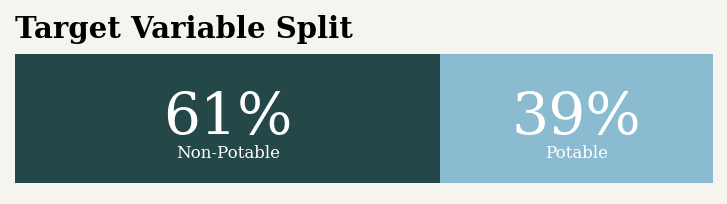

In [8]:
# Data
target_split = pd.DataFrame(round((df.groupby(['Potability'])['Potability'].count())/len(df),2)).T

# Plot
fig, ax = plt.subplots(1,1, figsize=(6,1.25), facecolor=background_color)

ax.barh(target_split.index, target_split[0], color='#244747')
ax.barh(target_split.index, target_split[1], left=target_split[0], color='#8abbd0')

ax.set(facecolor=background_color, xlim=[0,1], xticks=[], yticks=[])

for s in ["top","right","left","bottom"]:
            ax.spines[s].set_visible(False)

# Annotations
for i in target_split.index:
    ax.annotate(f"{int(target_split[0][i]*100)}%", xy=(target_split[0][i]/2, i),
                   va = 'center', ha='center',fontsize=28,color='white')
    ax.annotate(f"{int(target_split[1][i]*100)}%", xy=(target_split[0][i]+target_split[1][i]/2, i),
                   va = 'center', ha='center',fontsize=28, color='white')
    
    ax.annotate("Non-Potable", xy=(target_split[0][i]/2, -0.22),
                   va = 'center', ha='center',fontsize=8, color='white')
    
    ax.annotate("Potable", xy=(target_split[0][i]+target_split[1][i]/2, -0.22),
                   va = 'center', ha='center',fontsize=8, color='white')

ax.text(0,0.5, "Target Variable Split", fontsize=14, fontweight='bold')

plt.show()

Most of our samples are non-potable.

We could deal with this imbalance using techniques such as SMOTE. However, this may not be necessary.

What about the distribution of our variables in relation to potability?

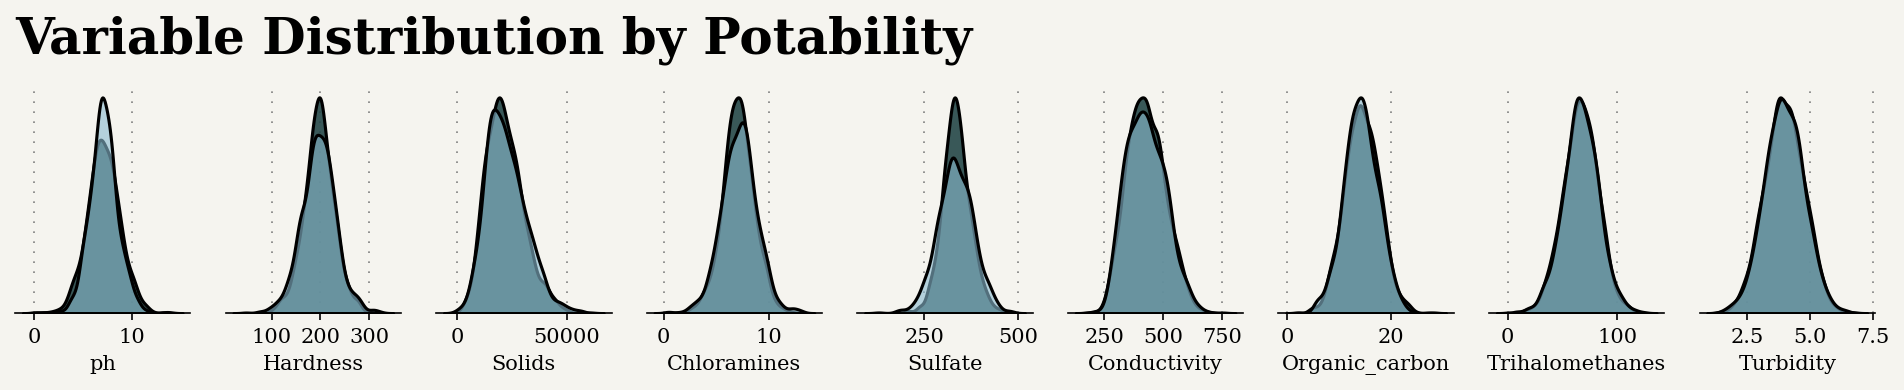

In [9]:
fig = plt.figure(figsize=(16, 2), facecolor=background_color)

gs = fig.add_gridspec(1, len(df.columns)-1)
gs.update(wspace=0.2, hspace=0.4)

# Build axes for plots

plot = 0
for row in range(0, 1):
    for col in range(0, len(df.columns)-1):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        locals()["ax"+str(plot)].set_axisbelow(True)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

# Plots

plot = 0

for variable in df.columns[:-1]:
        sns.kdeplot(df.query("Potability == 0")[variable],ax=locals()["ax"+str(plot)], color='#244747', shade=True, ec='black',linewidth=1.5, alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(df.query("Potability == 1")[variable], ax=locals()["ax"+str(plot)], color='#8abbd0',ec='black', shade=True, linewidth=1.5, alpha=0.6, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))
        locals()["ax"+str(plot)].set_xlabel(variable)
        plot += 1
               
Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.text(Xstart, Yend+(Yend*0.15), 'Variable Distribution by Potability', fontsize=24, fontweight='bold')

plt.show()

**What does this tell us?**

There do not seem to be clear differences between the variables when looking for Potability status.

This might suggest that no one feature on it's own can be used as a powerful indicator, though we will continue to investigate this throughout the notebook.

I'll plot all of our 9 variables against one another to see if we can view anything en masse that could be worth exploring.

To do so, let's figure out how many unique pairs we'll have to plot (order does not matte, e.g. ph & hardness is the same as hardness & ph)

In [10]:
def n_choose_k_unordered_combinations(n,k):
    
    # n is how many there are in total, and k is how many you'd like to chose
    # returns number of unique combinations where order does not matter

    import math
    print(color.S+"Unordered Combinations"+color.E)
    print(int(math.factorial(n)/(math.factorial(k)*(math.factorial(n-k)))),f"ways to choose {k} items from {n}")
    

n_choose_k_unordered_combinations(9,2)

Unordered Combinations
36 ways to choose 2 items from 9


We can explicitly view these combinations if we wish:

In [11]:
import itertools
combinations = list(itertools.combinations(variables, 2))
print(len(combinations))
combinations

36


[('ph', 'Hardness'),
 ('ph', 'Solids'),
 ('ph', 'Chloramines'),
 ('ph', 'Sulfate'),
 ('ph', 'Conductivity'),
 ('ph', 'Organic_carbon'),
 ('ph', 'Trihalomethanes'),
 ('ph', 'Turbidity'),
 ('Hardness', 'Solids'),
 ('Hardness', 'Chloramines'),
 ('Hardness', 'Sulfate'),
 ('Hardness', 'Conductivity'),
 ('Hardness', 'Organic_carbon'),
 ('Hardness', 'Trihalomethanes'),
 ('Hardness', 'Turbidity'),
 ('Solids', 'Chloramines'),
 ('Solids', 'Sulfate'),
 ('Solids', 'Conductivity'),
 ('Solids', 'Organic_carbon'),
 ('Solids', 'Trihalomethanes'),
 ('Solids', 'Turbidity'),
 ('Chloramines', 'Sulfate'),
 ('Chloramines', 'Conductivity'),
 ('Chloramines', 'Organic_carbon'),
 ('Chloramines', 'Trihalomethanes'),
 ('Chloramines', 'Turbidity'),
 ('Sulfate', 'Conductivity'),
 ('Sulfate', 'Organic_carbon'),
 ('Sulfate', 'Trihalomethanes'),
 ('Sulfate', 'Turbidity'),
 ('Conductivity', 'Organic_carbon'),
 ('Conductivity', 'Trihalomethanes'),
 ('Conductivity', 'Turbidity'),
 ('Organic_carbon', 'Trihalomethanes'),
 

And to plot them

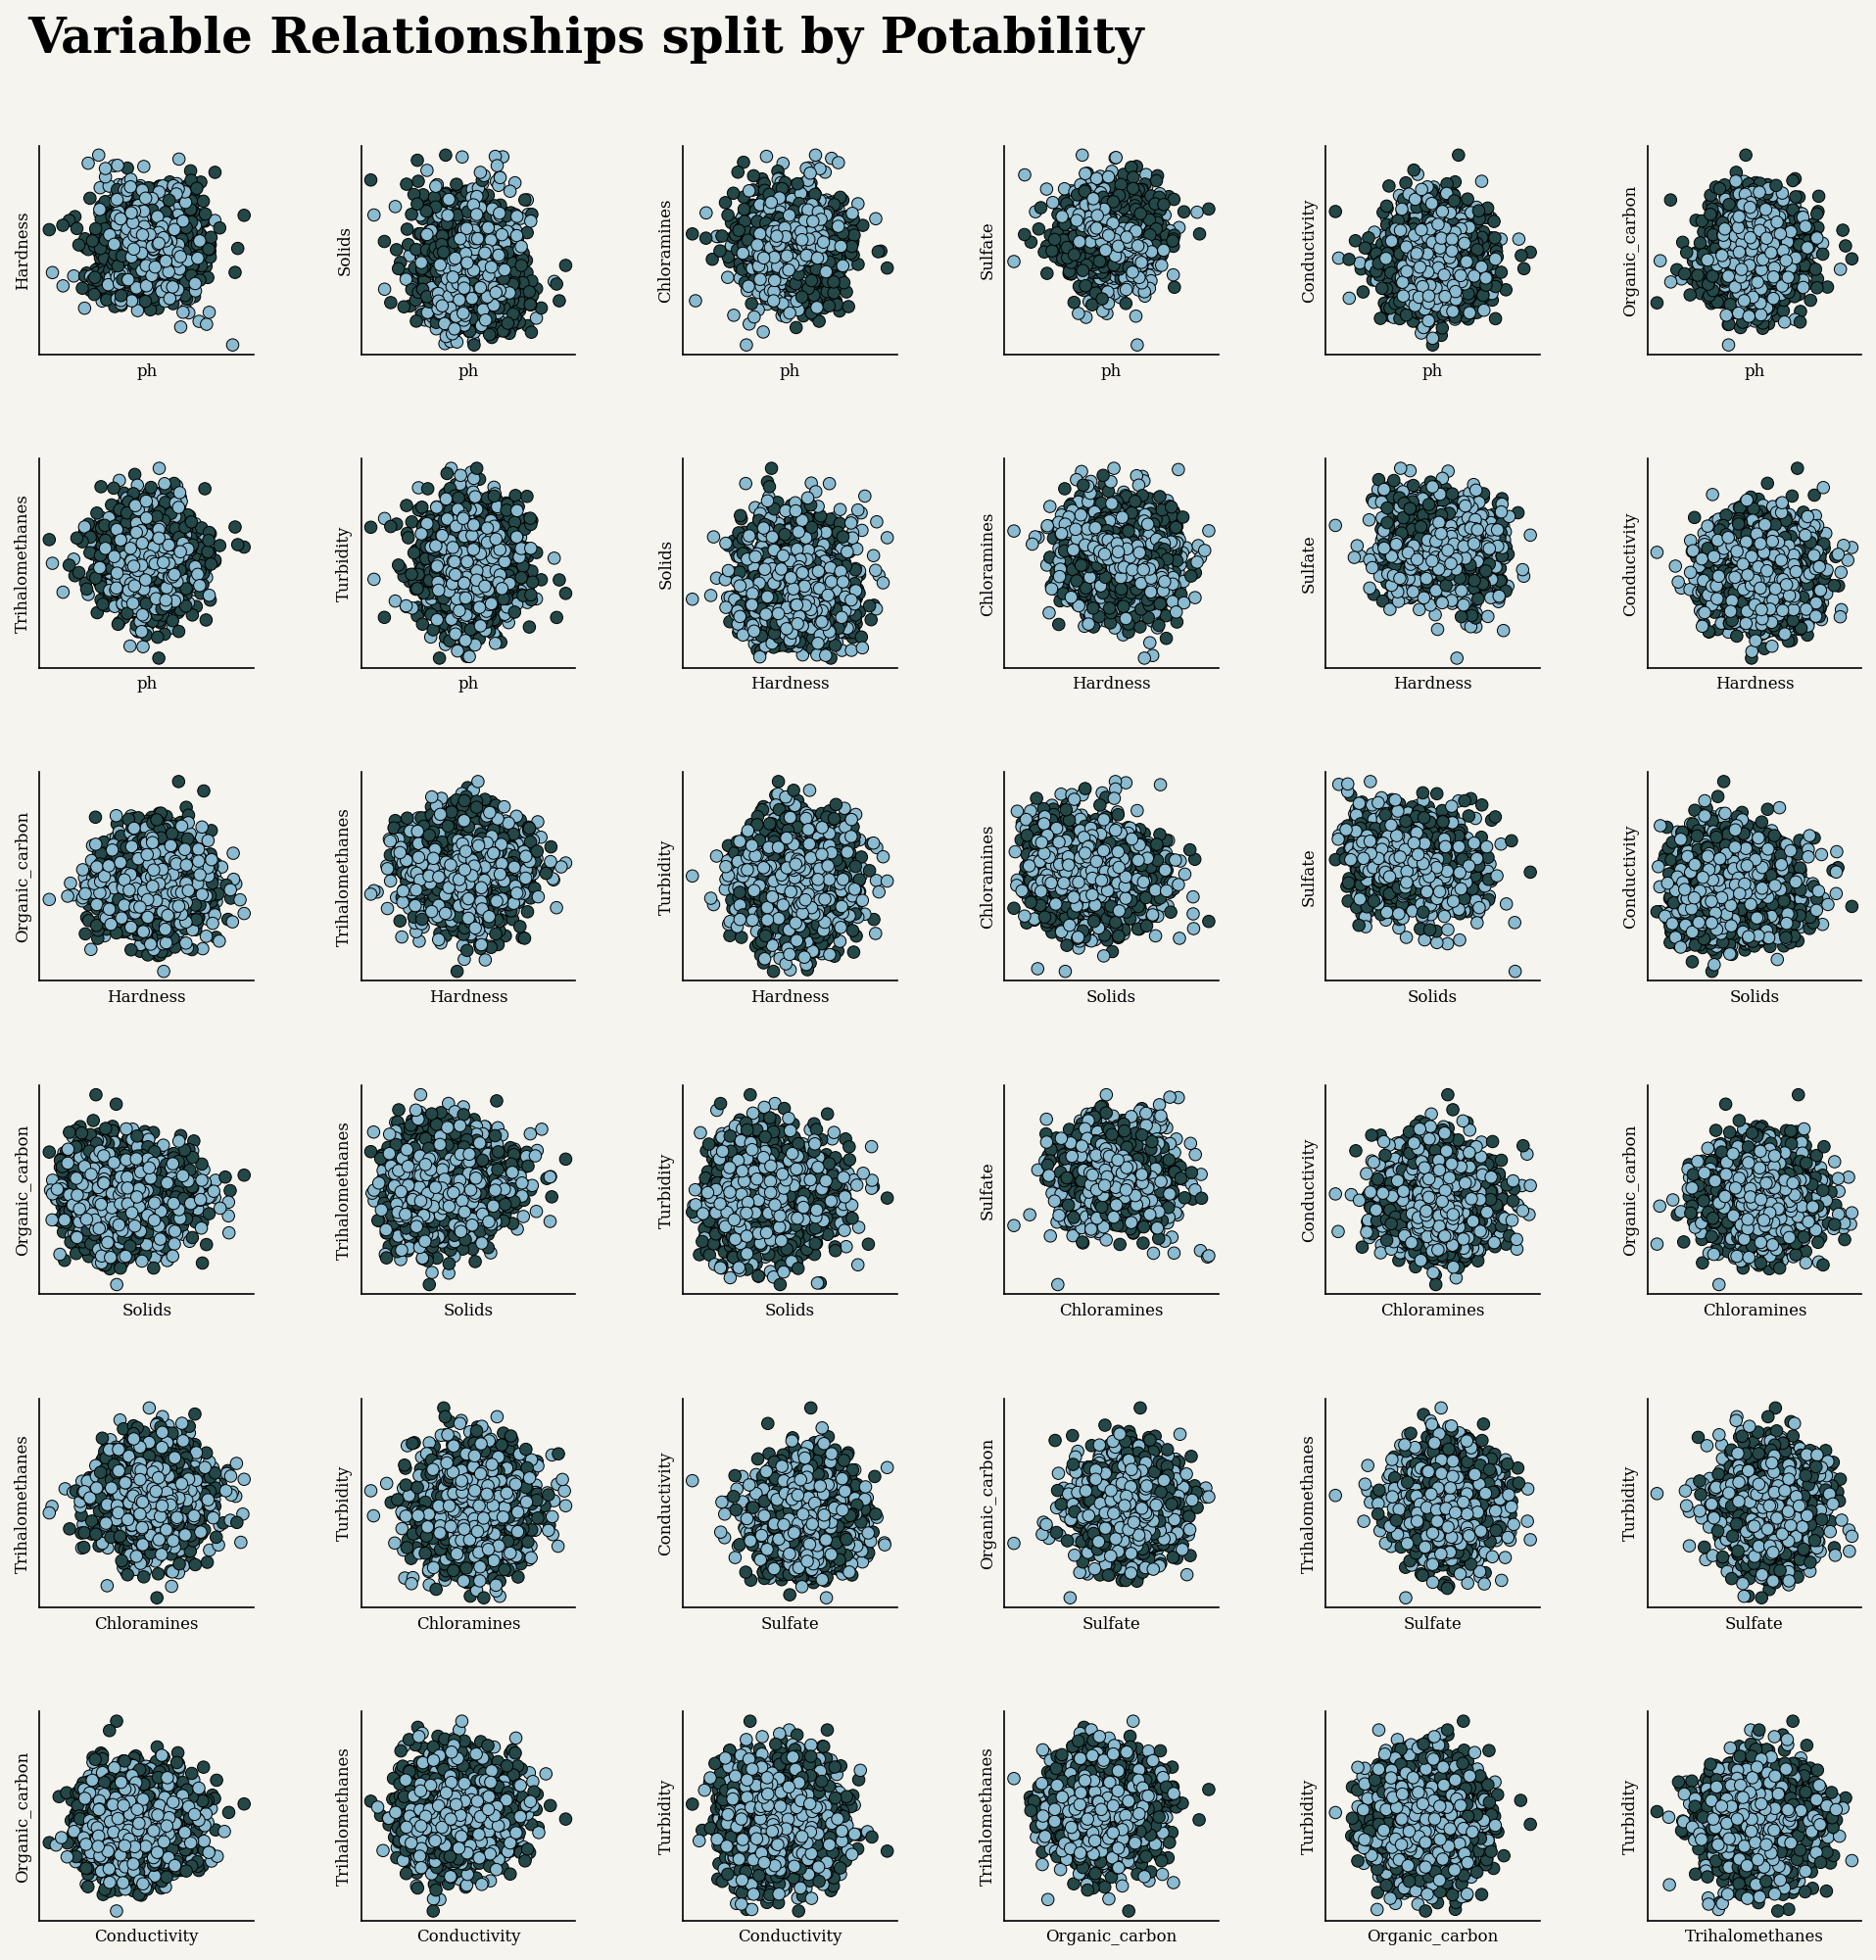

In [12]:
fig = plt.figure(figsize=(16, 16), facecolor=background_color)

plot = 0 

combinations = list(itertools.combinations(variables, 2))

for item in combinations:
            
        plot += 1
        
        plt.subplot(6 , 6, plot, facecolor=background_color)
        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        
        sns.scatterplot(x=item[0] ,y=item[1] , data=df, hue=df['Potability'], palette=['#244747','#8abbd0'], ec='black', lw=1.5, legend=False)
        sns.despine()
        
        plt.ylabel(item[1], fontsize=8)
        plt.xlabel(item[0], fontsize=8)
        plt.yticks([])
        plt.xticks([])        
        
fig.text(0.12,0.92,'Variable Relationships split by Potability', fontsize=24, fontweight='bold')
plt.show()

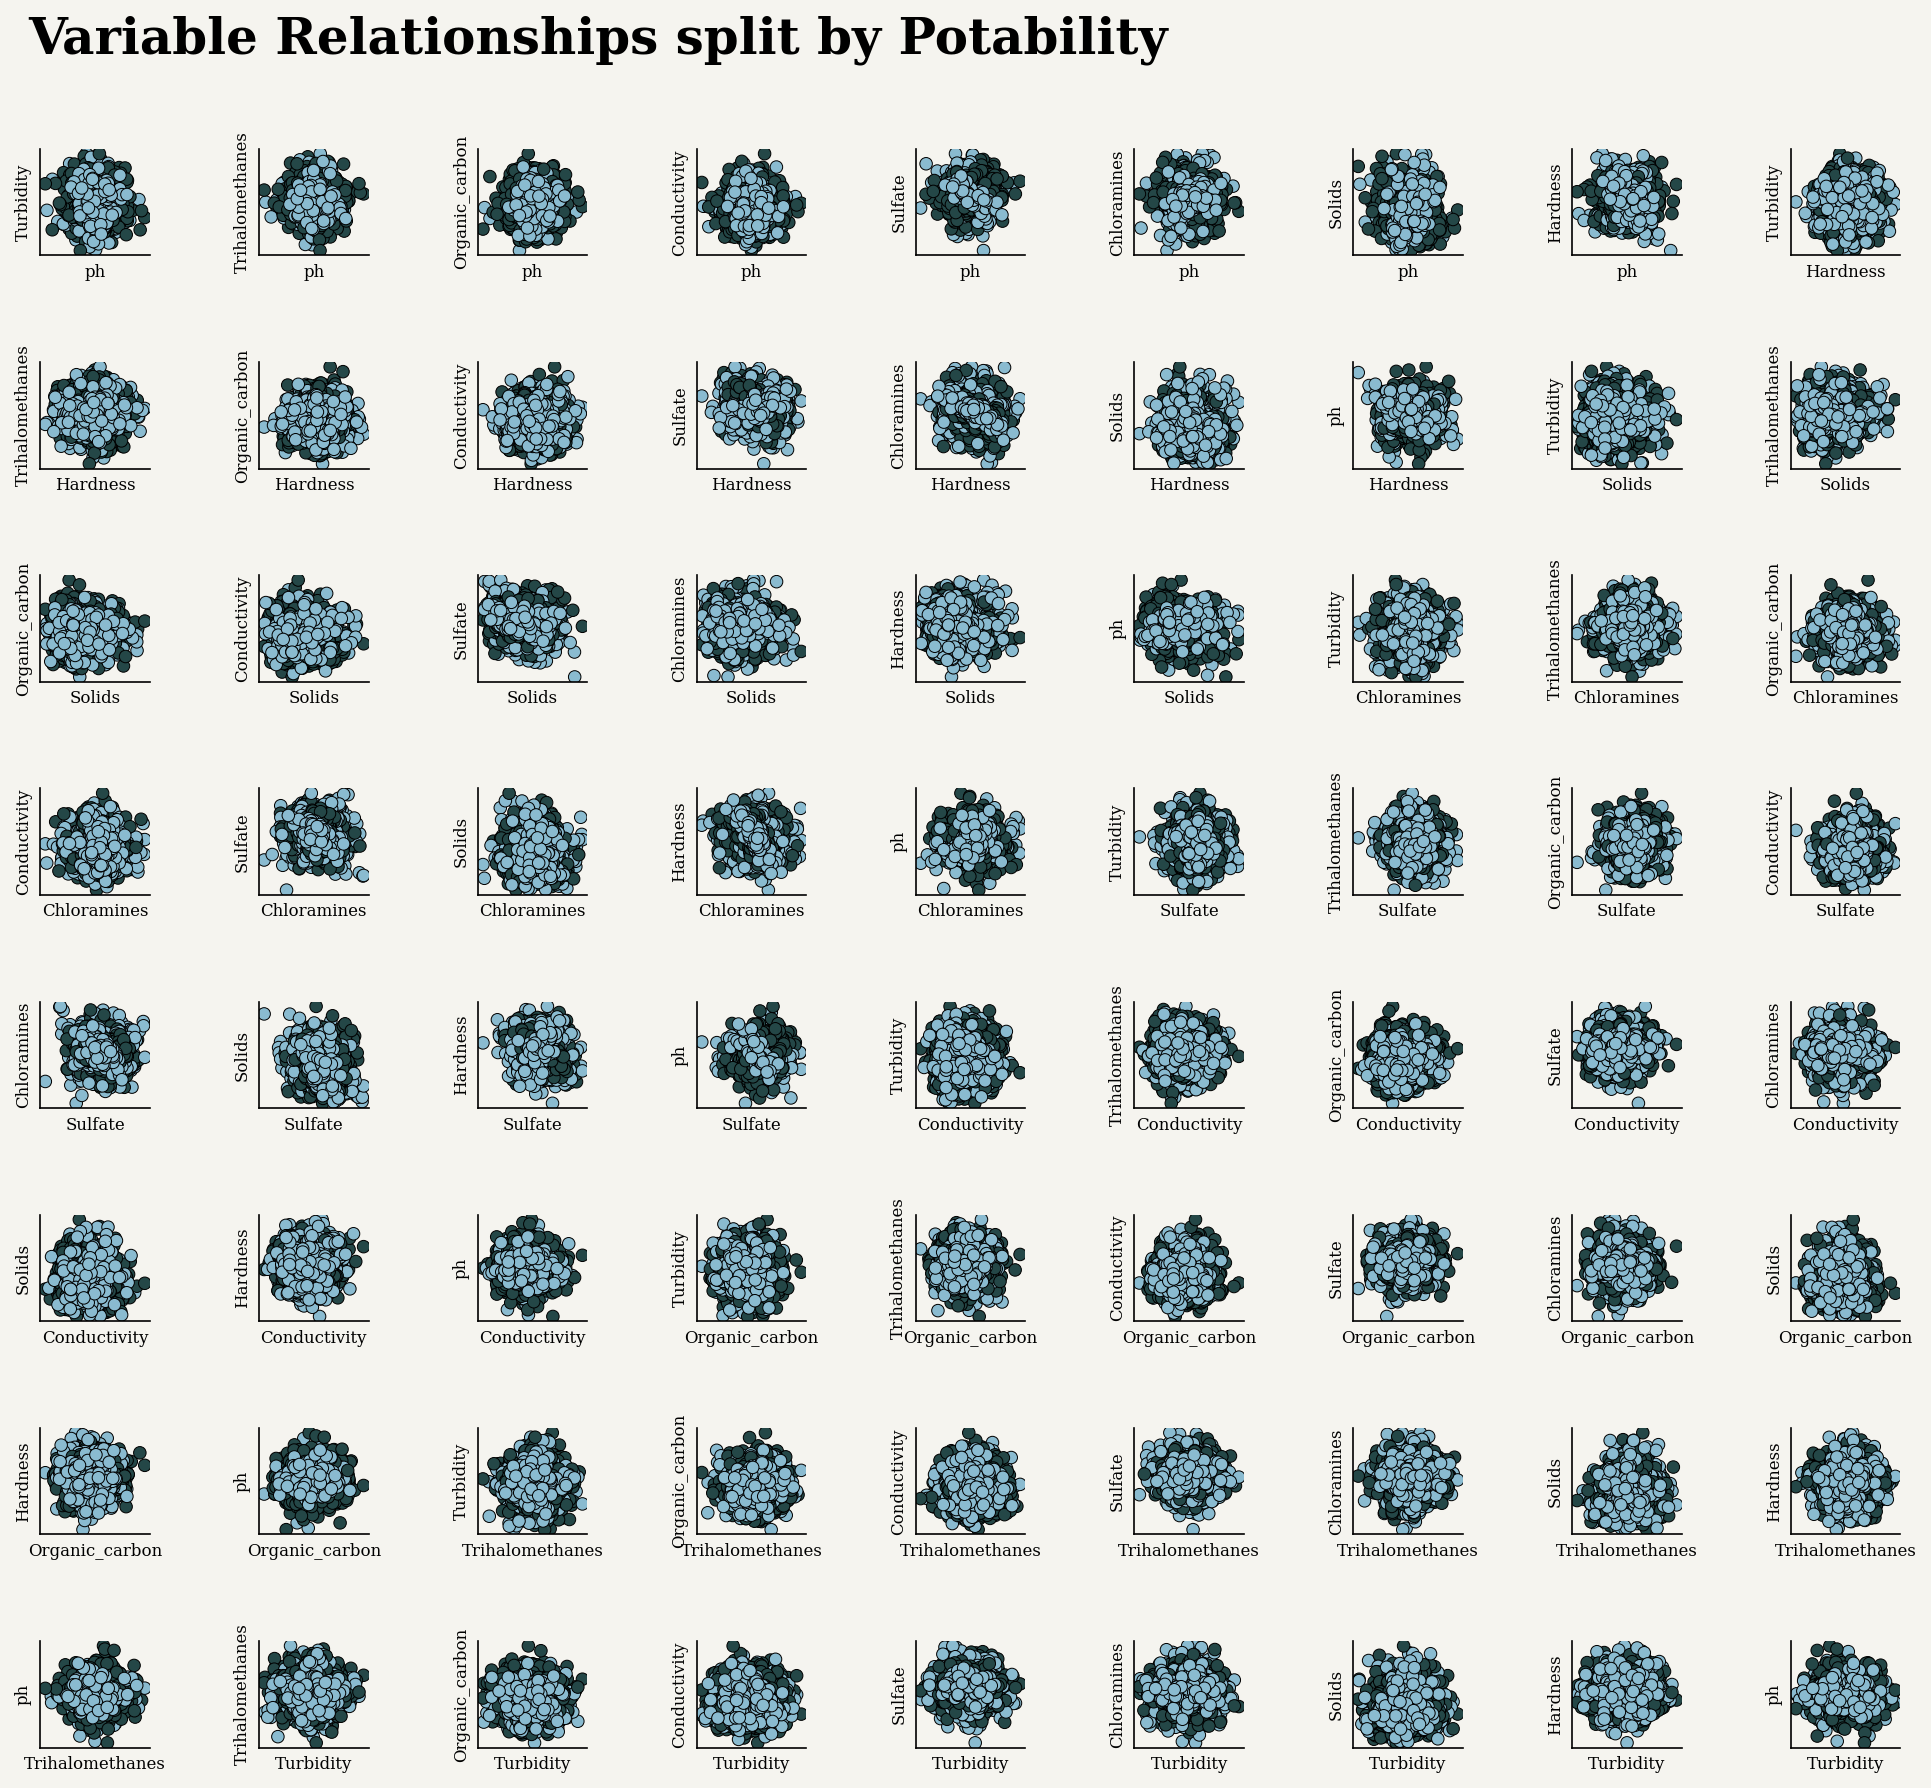

In [13]:
fig = plt.figure(figsize=(16, 16), facecolor=background_color)

plot = 0 

for x in variables:
    for y in variables[::-1]:
        if x==y: continue
            
        plot += 1
        
        plt.subplot(9 , 9, plot, facecolor=background_color)
        plt.subplots_adjust(hspace=1, wspace=1)
        
        sns.scatterplot(x=x ,y=y , data=df, hue=df['Potability'], palette=['#244747','#8abbd0'], ec='black', lw=1.5, legend=False)
        sns.despine()
        
        plt.ylabel(y, fontsize=8)
        plt.xlabel(x, fontsize=8)
        plt.yticks([])
        plt.xticks([])
        
fig.text(0.12,0.92,'Variable Relationships split by Potability', fontsize=24, fontweight='bold')
plt.show()

**What does this tell us?**

This is a pretty overwhelming plot. It doesn't show us a whole lot as there is far too much information to take in at once. 

However, the benefit of this type of plotting can be to quickly assess, roughly, if there are certain areas we wish to 'zoom in' and focus on.

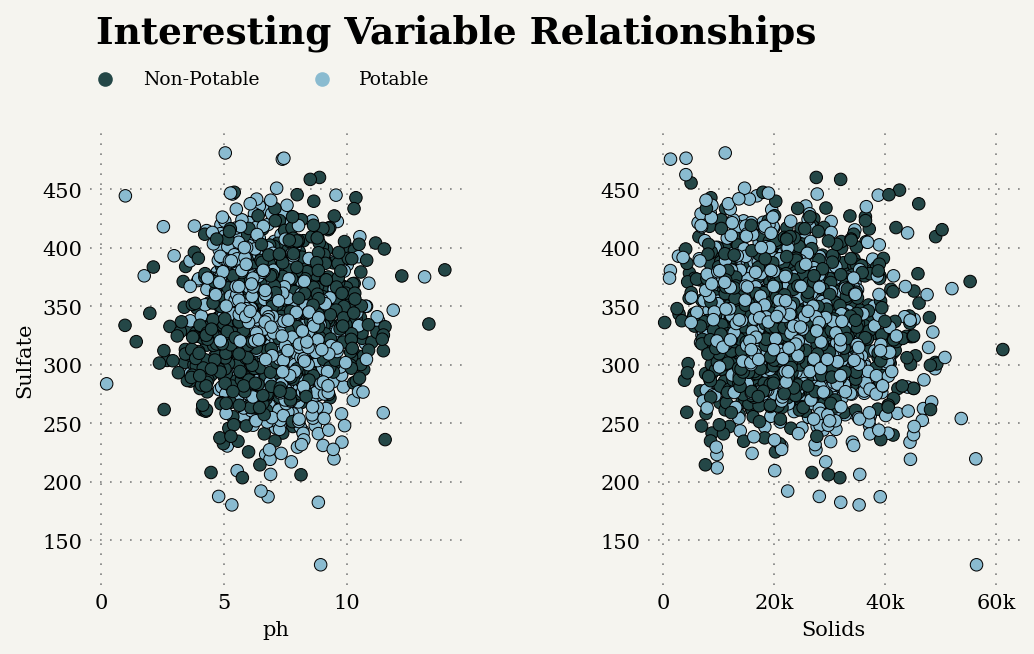

In [14]:
fig = plt.figure(figsize=(8,4), facecolor=background_color)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.5, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

sns.scatterplot(data=df, x='ph', y='Sulfate', hue='Potability',palette=['#244747','#8abbd0'], ec='black', lw=1.5, ax=ax0)
sns.scatterplot(data=df, x='Solids', y='Sulfate', hue='Potability',palette=['#244747','#8abbd0'], ec='black', lw=1.5, legend=False, ax=ax1)
     
for i in range(0, 2):
        locals()["ax"+str(i)].tick_params(axis='both', which='both', length=0)
        locals()["ax"+str(i)].set_facecolor(background_color)
        locals()["ax"+str(i)].grid(which='both', axis='both', zorder=5, color='gray', linestyle=':', dashes=(1,5))
        locals()["ax"+str(i)].set_axisbelow(True)
        for s in ["top","right","left","bottom"]:
            locals()["ax"+str(i)].spines[s].set_visible(False)

ax1.set_ylabel('') # Turned off y label for second plot as is the same as the first

def x_formatter(x, pos):
    """The two args are the value and tick position"""
    if x <= 0:
        label = '0'

    elif x >= 1e6:
        label = '{:1.1f}M'.format(x*1e-6)
        
    else:
        label = '{:1.0f}k'.format(x*1e-3)
    return label

ax1.xaxis.set_major_formatter(x_formatter)

# Legend

L = ax0.legend(frameon=False,loc="upper center", bbox_to_anchor=(0.45, 1.18), ncol= 2)
plt.setp(L.texts, family='serif', size=9) 
L.get_frame().set_facecolor('none')
L.get_texts()[0].set_text('Non-Potable')
L.get_texts()[1].set_text('Potable')

ax0.text(-0.2,575,'Interesting Variable Relationships', fontsize=18, fontweight='bold')

plt.show()

**What does this tell us?**

Well here we can clearly see a difference between Potable & Non-Potable samples, especially with relation to ph & Sulfate.

When water is Potable, we observe a relatively strong inverse relationship between the two variables; as ph increases, Sulfate levels decrease. This does not look to be the case with Non-Potable samples.

To a lesser extent, this looks to also be true with Solids & ph.

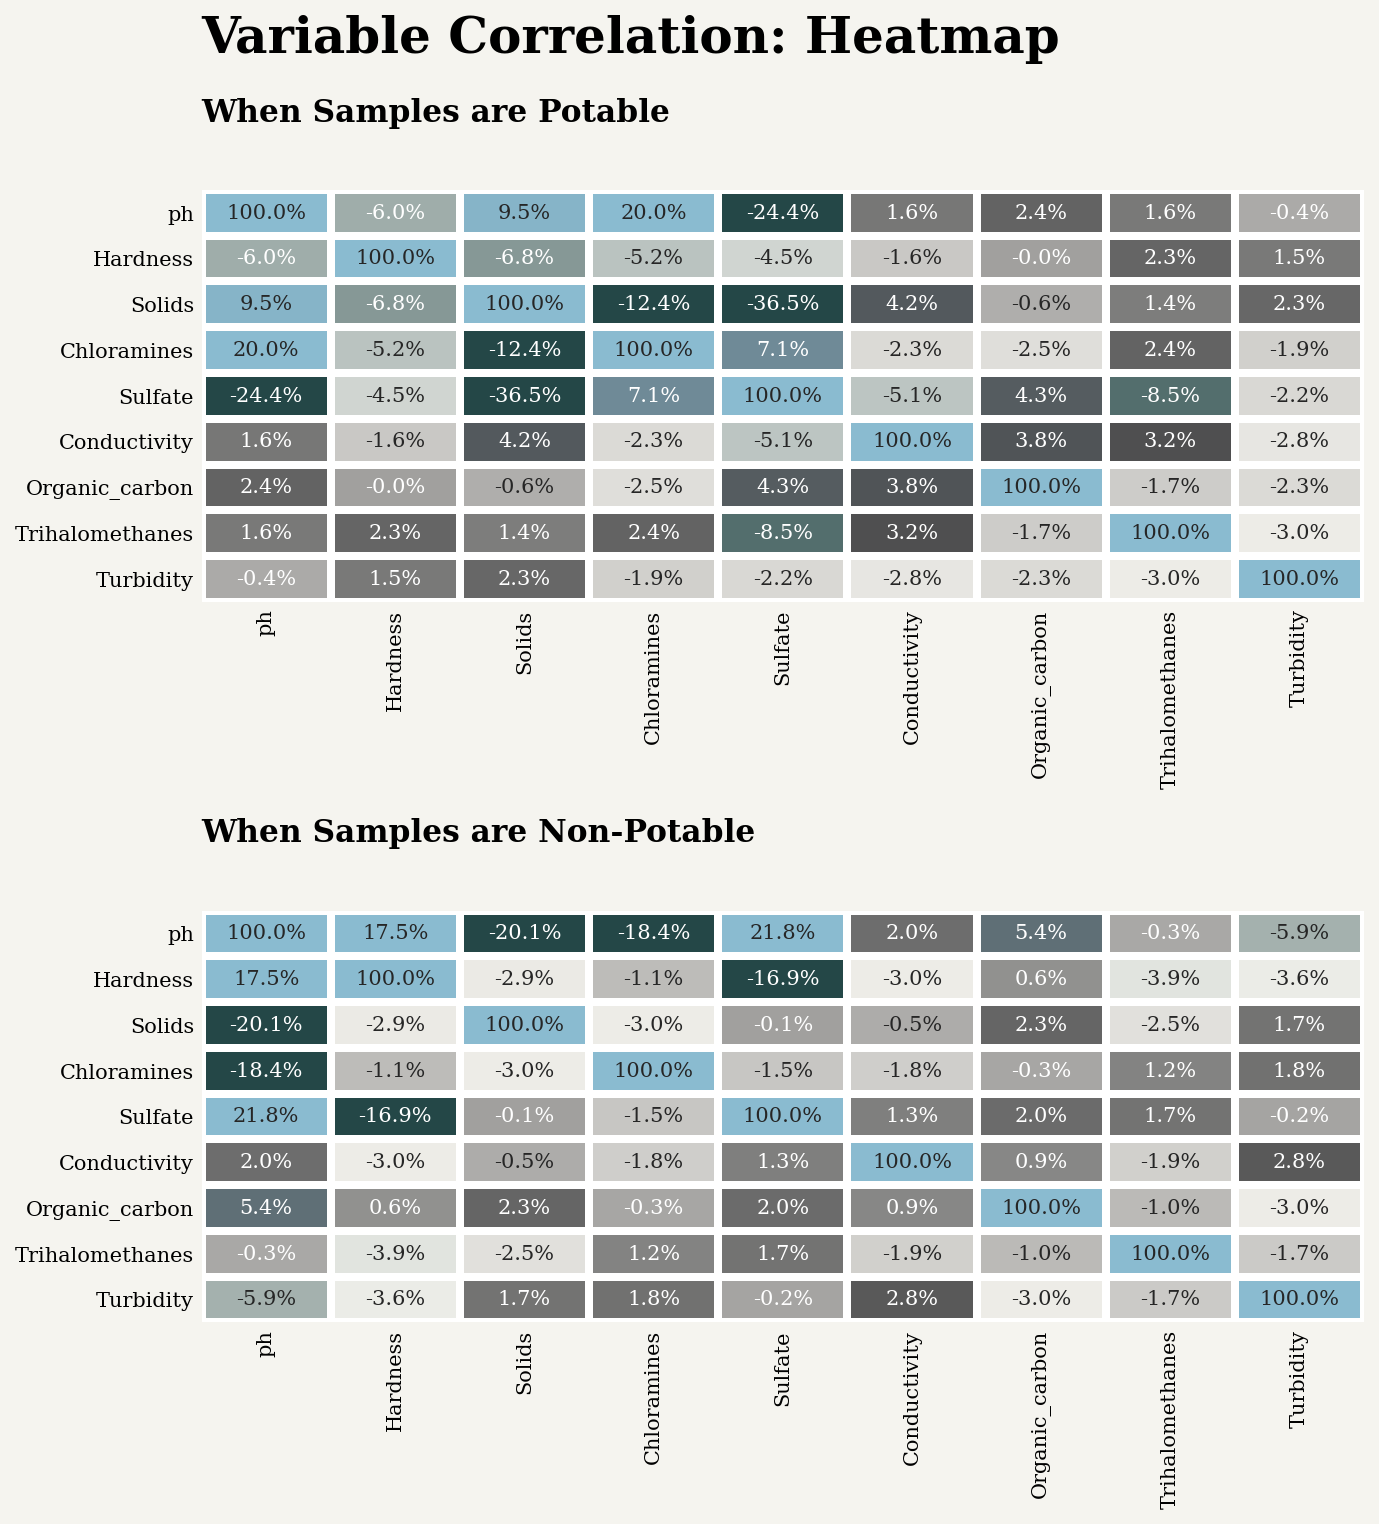

In [15]:
# Custom color map
colors = ["#244747","#f5f4ef", "#4b4b4c","#8abbd0"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

fig = plt.figure(figsize=(10,10), facecolor=background_color)
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.5, hspace=0.75)
ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])

# Hides top right of heatmap
#mask = np.triu(np.ones_like(corr, dtype=np.bool))
#np.tril(corr) for hiding the lower left corner instead

corr_1 = df.query("Potability == 1")[variables].corr()
corr_0 = df.query("Potability == 0")[variables].corr()

# Heatmap
sns.heatmap(corr_1, linewidth=3, annot=True, fmt='.1%', cbar=False, cmap=colormap, vmin=-0.1, vmax=0.1, ax=ax0)
sns.heatmap(corr_0, linewidth=3, annot=True, fmt='.1%', cbar=False, cmap=colormap, vmin=-0.1, vmax=0.1, ax=ax1)

for i in range(0, 2):
        locals()["ax"+str(i)].tick_params(axis='both', which='both', length=0)
        locals()["ax"+str(i)].set_facecolor(background_color)
# Text
ax0.text(0,-3,'Variable Correlation: Heatmap',fontsize=24, fontweight='bold')
ax0.text(0,-1.5,'When Samples are Potable',fontsize=15, fontweight='bold')

ax1.text(0,-1.5,'When Samples are Non-Potable',fontsize=15, fontweight='bold')


plt.show()

**What does this tell us?**

As we noticed in the scatter plots above, we now see formally that variables have differing relationships between one another when split by Potability.

This is good news from a modelling perspective. **We have uncovered some previously hidden insights in our data**.

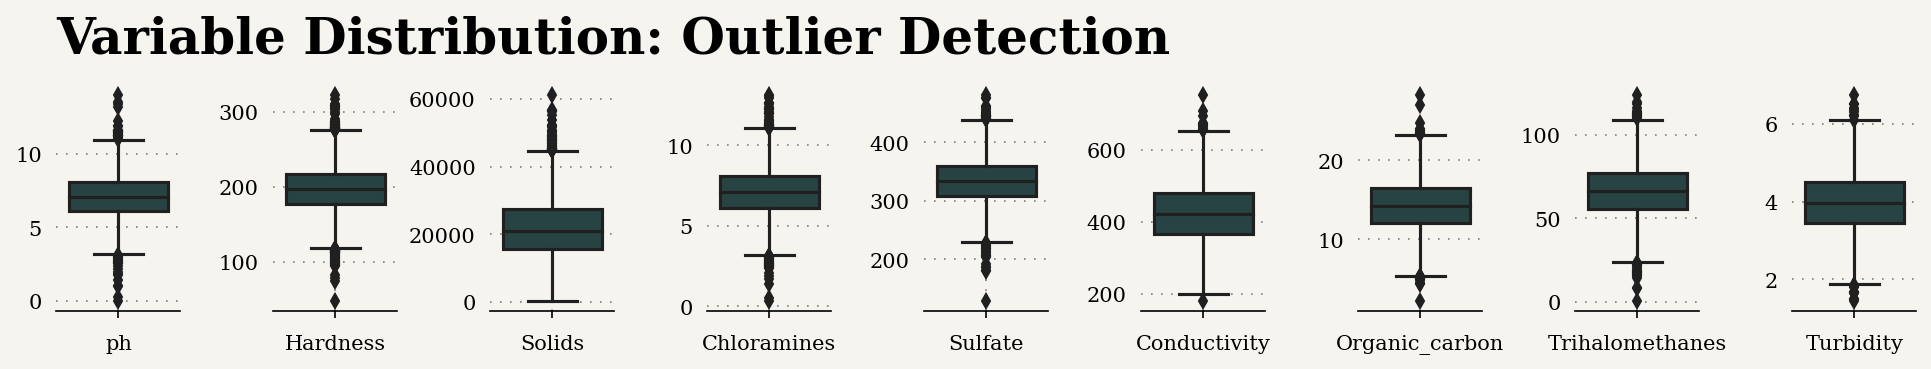

In [16]:
fig = plt.figure(figsize=(16, 2), facecolor=background_color)

gs = fig.add_gridspec(1, len(df.columns)-1)
gs.update(wspace=0.75, hspace=0.4)

# Build axes for plots

plot = 0
for row in range(0, 1):
    for col in range(0, len(df.columns)-1):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        #locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        locals()["ax"+str(plot)].set_axisbelow(True)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

# Plots

plot = 0

for variable in df.columns[:-1]:
        sns.boxplot(data=df, y=df[variable],ax=locals()["ax"+str(plot)], color='#244747')
        locals()["ax"+str(plot)].grid(which='both', axis='both', zorder=5, color='gray', linestyle=':', dashes=(1,5))
        locals()["ax"+str(plot)].set_xlabel(variable)
        locals()["ax"+str(plot)].set_ylabel('')

        plot += 1
        
        
Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()
ax0.text(Xstart, Yend+(Yend*0.15), 'Variable Distribution: Outlier Detection', fontsize=24, fontweight='bold')

plt.show()

View with Boxen Plots

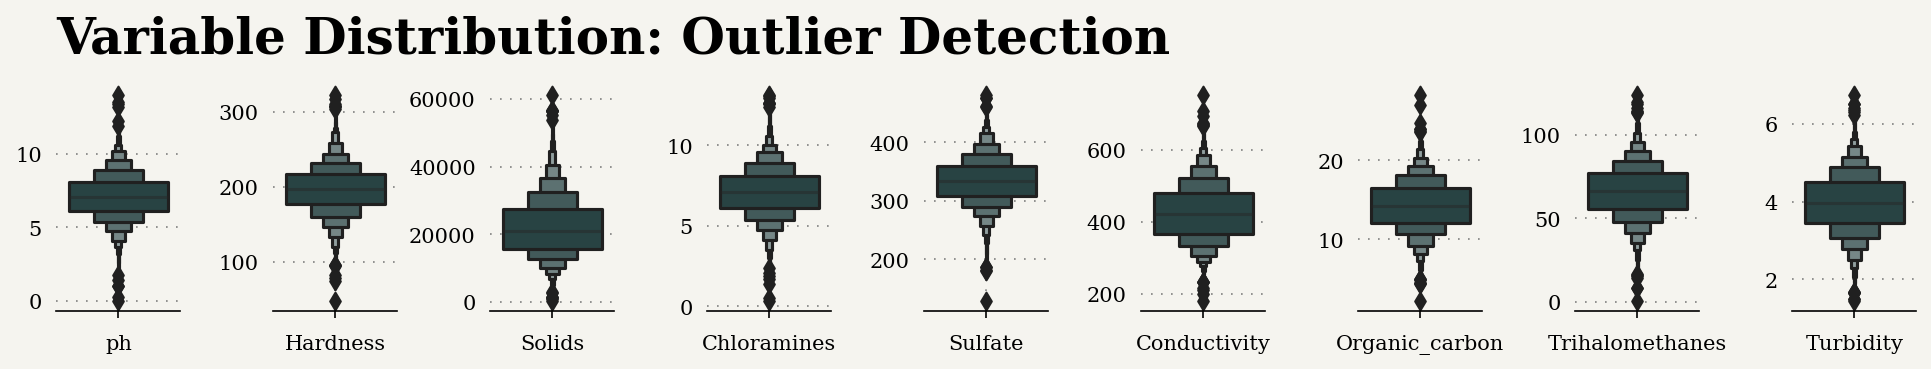

In [17]:
fig = plt.figure(figsize=(16, 2), facecolor=background_color)

gs = fig.add_gridspec(1, len(df.columns)-1)
gs.update(wspace=0.75, hspace=0.4)

# Build axes for plots

plot = 0
for row in range(0, 1):
    for col in range(0, len(df.columns)-1):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        #locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        locals()["ax"+str(plot)].set_axisbelow(True)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

# Plots

plot = 0

for variable in df.columns[:-1]:
        sns.boxenplot(data=df, y=df[variable],ax=locals()["ax"+str(plot)], color='#244747')
        locals()["ax"+str(plot)].grid(which='both', axis='both', zorder=5, color='gray', linestyle=':', dashes=(1,5))
        locals()["ax"+str(plot)].set_xlabel(variable)
        locals()["ax"+str(plot)].set_ylabel('')

        plot += 1
        
        
Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()
ax0.text(Xstart, Yend+(Yend*0.15), 'Variable Distribution: Outlier Detection', fontsize=24, fontweight='bold')

plt.show()

For now, I will leave the data as it is.

# **Splitting our data**

In [18]:
y = df['Potability']
X = df.drop(['Potability'], axis=1)

# Split our data
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
for i in null_cols:
    print(i, "Train ",X_train[i].mean())
    print(i, "Test ",X_test[i].mean())

ph Train  7.088975549029737
ph Test  7.048289460392541
Sulfate Train  333.65330158520135
Sulfate Test  334.2572051205811
Trihalomethanes Train  66.35513177285068
Trihalomethanes Test  66.56153418118986


# **Dealing with Missing Values**

I will impute the missing values as simply the mean for the column. 

Importantly, I will use calculate the **mean of the training set only**. The reason for this is to **prevent data leakage**.

If you use the mean of the entire dataset, you are gaining information from your test data, and as such, you may overfit to our specific case. We want our model to be able to deal with unseen data.


In [20]:
for dataframe in [X_train, X_test]:
    for column in variables:
        column_value=X_train[column].mean()
        dataframe[column].fillna(column_value, inplace=True)   
        
# Note, all of our columns are 'float64' so we can impute as above
# If we had Categorical features, e.g. 'Object' data types, we could impute the 'Mode' (most common value)
# For example:
# for dataframe in [X_train, X_test]:
#    dataframe[catergorical_variable].fillna(X_train[catergorical_variable].mode()[0], inplace=True)

In [21]:
print(color.S+"Null Values:"+color.E)
for dataframe in [X_train, X_test]:
    print(dataframe.isnull().sum().sum())

Null Values:
0
0


# **Modelling**

Whe dealing with classification problems, there are often a frew questions worth bearing in mind when assessing model performance:

* What is a 'good' score?

For this, I like to set an initial **baseline as the 'Null Accuracy' score**. In other words, If I just predicted the most common answer for every input, what would my accuracy score be?

* Could False Positives or False Negatives have a disastrous impact?

This is more common on, say, Medical datasets. If a model predicts a False Negative it could quite literally have life-threatening effects.

* Based on the above, is your chosen error-metric suitable?

**First: Scaling the data**

This can be done manually, or through a library like Sklearn. 

There are several methods of scaling data. Two popular methods are **z-standardisation & Min-Max Scaling**.

Z-standardisation represents how many standard deviations a point is from the mean.

Whilst Min-Max scaling transforms the data so that it is between 0 & 1.

I'll try both to see how if this influences model performance

In [22]:
min_max_scaler = MinMaxScaler()
X_train_min_max_scaled = min_max_scaler.fit_transform(X_train)
X_test_min_max_scaled = min_max_scaler.transform(X_test)

standard_scaler = StandardScaler()
X_train_stand_scaled = standard_scaler.fit_transform(X_train)
X_test_stand_scaled = standard_scaler.transform(X_test)

Convert to DataFrame

In [23]:
X_train_min_max_scaled = pd.DataFrame(X_train_min_max_scaled, columns=variables)
X_test_min_max_scaled = pd.DataFrame(X_test_min_max_scaled, columns=variables)

X_train_stand_scaled = pd.DataFrame(X_train_stand_scaled, columns=variables)
X_test_stand_scaled = pd.DataFrame(X_test_stand_scaled, columns=variables)

Viewing the differences

In [24]:
X_train_stand_scaled.head(3).style.set_caption('X Train: Standard Scaling')

In [25]:
X_train_min_max_scaled.head(3).style.set_caption('X Train: Min-Max Scaling')

**Null Accuracy**

This can serve as a baseline for us to beat. 

The Null accuracy would be the score if you always predicted the most common classification. In this case, all zeroes.

In [26]:
print(color.S+"Null Accuracy Score:"+color.E,round(y_test.value_counts()[0]/(y_test.value_counts().sum()),4))

Null Accuracy Score: 0.628


**Models**

We could run through each model in turn as below, but instead, I will loop through a selection of machine learning models to which may have promise.

We can then look to fine tune these models to improve the score further.

In [27]:
logistic_regression = LogisticRegression(random_state=0)
logistic_regression.fit(X_train_min_max_scaled, y_train)
log_pred_min_max = logistic_regression.predict(X_test_min_max_scaled)

print(color.S+'Model accuracy score:'+color.E,' {0:0.4f}'. format(accuracy_score(y_test, log_pred_min_max)))
print(color.S+'Confusion Matrix:'+color.E,'\n',confusion_matrix(y_test, log_pred_min_max))

Model accuracy score:  0.6280
Confusion Matrix: 
 [[412   0]
 [244   0]]


We can see here that Logisitc Regression only matches the Null Accuracy score. Indeed, it predicts the negative class every time.

The code below shows all the predictions are zeroes!

In [28]:
np.unique(log_pred_min_max)

array([0])

The models I will be trialing are listed below.

First, I will run through the models using the unscaled data, then I will repeat using scale data.

In [29]:
models = {
    "Logistic Regression": LogisticRegression(random_state=0),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "K-Nearest Neighbours": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC()
}

**Unscaled Data**

In [30]:
model_df = []
accuracy = []
precision = []
recall = []
f1 = []

for model, model_launch in models.items():
    
    # Loop through listed models
    model_initiated = model_launch
    model_initiated.fit(X_train, y_train)
    predictions = model_initiated.predict(X_test)
    
    # Model Names
    model_df.append(model)
    
    # Model Scores
    accuracy.append(accuracy_score(y_test, predictions))
    precision.append(precision_score(y_test, predictions))
    recall.append(recall_score(y_test, predictions))
    f1.append(f1_score(y_test, predictions))
    
    # Model Names & Scores in to a DataFrame
    
    scores_df = pd.DataFrame({'Model':model_df,
                              'Accuracy': accuracy, 
                              'Precision': precision,
                              'Recall': recall,
                              'F1':f1}).sort_values(by='Accuracy', ascending=False)
    
    
# Stylised DataFrame to help quickly grasp top performing models across metrics
scores_df

(scores_df.style
  .background_gradient(cmap=colormap, subset=['Accuracy','Precision','Recall','F1'])
  .highlight_max(subset=['Accuracy','Precision','Recall','F1'], color='gold')
  .set_caption('Model Performance with Unscaled Data')
  .format({'Accuracy': "{:.2%}",
           'Precision': "{:.2%}",
           'Recall': "{:.2%}",
           'F1': "{:.2%}"
          }))

**Min-Max Scaled Data**

In [31]:
model_df = []
accuracy = []
precision = []
recall = []
f1 = []

for model, model_launch in models.items():
    
    # Loop through listed models
    model_initiated = model_launch
    model_initiated.fit(X_train_min_max_scaled, y_train)
    predictions = model_initiated.predict(X_test_min_max_scaled)
    
    # Model Names
    model_df.append(model)
    
    # Model Scores
    accuracy.append(accuracy_score(y_test, predictions))
    precision.append(precision_score(y_test, predictions))
    recall.append(recall_score(y_test, predictions))
    f1.append(f1_score(y_test, predictions))
    
    # Model Names & Scores in to a DataFrame
    
    scores_df_min_max = pd.DataFrame({'Model':model_df,
                              'Accuracy': accuracy, 
                              'Precision': precision,
                              'Recall': recall,
                              'F1':f1}).sort_values(by='Accuracy', ascending=False)
    
    
    
# Stylised DataFrame to help quickly grasp top performing models across metrics
scores_df_min_max

(scores_df_min_max.style
  .background_gradient(cmap=colormap, subset=['Accuracy','Precision','Recall','F1'])
  .highlight_max(subset=['Accuracy','Precision','Recall','F1'], color='gold')
  .set_caption('Model Performance with Min-Max Scaled X Data')
  .format({'Accuracy': "{:.2%}",
           'Precision': "{:.2%}",
           'Recall': "{:.2%}",
           'F1': "{:.2%}"
          }))

**Z-Standardised Data**

In [32]:
model_df = []
accuracy = []
precision = []
recall = []
f1 = []

for model, model_launch in models.items():
    
    # Loop through listed models
    model_initiated = model_launch
    model_initiated.fit(X_train_stand_scaled, y_train)
    predictions = model_initiated.predict(X_test_stand_scaled)
    
    # Model Names
    model_df.append(model)
    
    # Model Scores
    accuracy.append(accuracy_score(y_test, predictions))
    precision.append(precision_score(y_test, predictions))
    recall.append(recall_score(y_test, predictions))
    f1.append(f1_score(y_test, predictions))
    
    # Model Names & Scores in to a DataFrame
    
    scores_df_stand = pd.DataFrame({'Model':model_df,
                              'Accuracy': accuracy, 
                              'Precision': precision,
                              'Recall': recall,
                              'F1':f1}).sort_values(by='Accuracy', ascending=False)
    
    
    
# Stylised DataFrame to help quickly grasp top performing models across metrics
scores_df_stand

(scores_df_stand.style
  .background_gradient(cmap=colormap, subset=['Accuracy','Precision','Recall','F1'])
  .highlight_max(subset=['Accuracy','Precision','Recall','F1'], color='gold')
  .set_caption('Model Performance with Standard Scaled X Data')
  .format({'Accuracy': "{:.2%}",
           'Precision': "{:.2%}",
           'Recall': "{:.2%}",
           'F1': "{:.2%}"
          }))



We observe above & below that the **scaled data out-performs the unscaled data**, on average, across every metric.

This is of course to be expected, but is nice to show it.

The **z-Standardised scaling outperforms the Min-Max scaling** on this particular dataset. Therefore, all future model tests will be done using the z-Standardised data.

In [33]:
print(color.S+'Average Scores by X Train Scaling'+color.E)
for i in [scores_df, scores_df_min_max, scores_df_stand]:
    print(i.mean(),'\n')

Average Scores by X Train Scaling
Accuracy     0.621951
Precision    0.338521
Recall       0.226093
F1           0.262742
dtype: float64 

Accuracy     0.648882
Precision    0.493554
Recall       0.295082
F1           0.355138
dtype: float64 

Accuracy     0.648120
Precision    0.482917
Recall       0.308743
F1           0.365099
dtype: float64 



**Model Performance Reminder**

Several models performed relatively well, with 3 outperforming the Null Accuracy score.

The most accurate models are: SVM, Random Forest, and Gradient Boosting.

However, KNN had the highest F1 score, so this can't be dismissed.

In [34]:
(scores_df_stand.style
  .background_gradient(cmap=colormap, subset=['Accuracy','Precision','Recall','F1'])
  .highlight_max(subset=['Accuracy','Precision','Recall','F1'], color='gold')
  .set_caption('Model Performance with Standard Scaled X Data')
  .format({'Accuracy': "{:.2%}",
           'Precision': "{:.2%}",
           'Recall': "{:.2%}",
           'F1': "{:.2%}"
          }))

# **Combining Models**

We see that the models above seem to perform differently across our error metrics. 

SVM, for example, has the highest Accuracy, but it's Recall is much lower than KNN. One way to try and get the benefits of many models is to use a voting classifier.

The idea behind the Voting Classifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

In [35]:
SVM = SVC(probability=True)
RF = RandomForestClassifier(random_state=0)
Decision_Tree = DecisionTreeClassifier(random_state=0)
KNN = KNeighborsClassifier(n_neighbors=5)

In [36]:
accuracy = []
precision = []
recall = []
f1 = []

Voting_Classifier = VotingClassifier(estimators=[('SVM',SVM),('RF',RF), ('Decision Tree',Decision_Tree),('KNN',KNN)],
                                     voting='soft',n_jobs=-1)

Voting_Classifier = Voting_Classifier.fit(X_train_stand_scaled, y_train)

predictions = Voting_Classifier.predict(X_test_stand_scaled)


# Model Scores
accuracy.append(accuracy_score(y_test, predictions))
precision.append(precision_score(y_test, predictions))
recall.append(recall_score(y_test, predictions))
f1.append(f1_score(y_test, predictions))

Voting_Class_df= pd.DataFrame({'Model':'Voting Classifier',
                          'Accuracy': accuracy, 
                          'Precision': precision,
                          'Recall': recall,
                          'F1':f1}).sort_values(by='Accuracy', ascending=False)

Let's see how the Voting Classifier performed. Note that I used the "Soft" vote rather than the "Hard" vote.

In [37]:
(Voting_Class_df.set_index('Model').style
  .background_gradient(cmap=colormap, subset=['Accuracy','Precision','Recall','F1'])
  .set_caption('Voting Classifier Performance')
  .format({'Accuracy': "{:.2%}",
           'Precision': "{:.2%}",
           'Recall': "{:.2%}",
           'F1': "{:.2%}"
          }))

It looks to have performed quite well. Let's compare this to the indivdual model performances

In [38]:
(Voting_Class_df.append(scores_df_stand).set_index('Model').sort_values(by='Accuracy', ascending=False).style
.background_gradient(cmap=colormap, subset=['Accuracy','Precision','Recall','F1'])
.highlight_max(subset=['Accuracy','Precision','Recall','F1'], color='gold')
.set_caption('Model Performance Overview')
.format({'Accuracy': "{:.2%}",
       'Precision': "{:.2%}",
       'Recall': "{:.2%}",
       'F1': "{:.2%}"
      }))

The Voting Classifer performed well. With the highest F1 score so far.

We can see where the classifier went wrong (and right) by using a confusion matrix

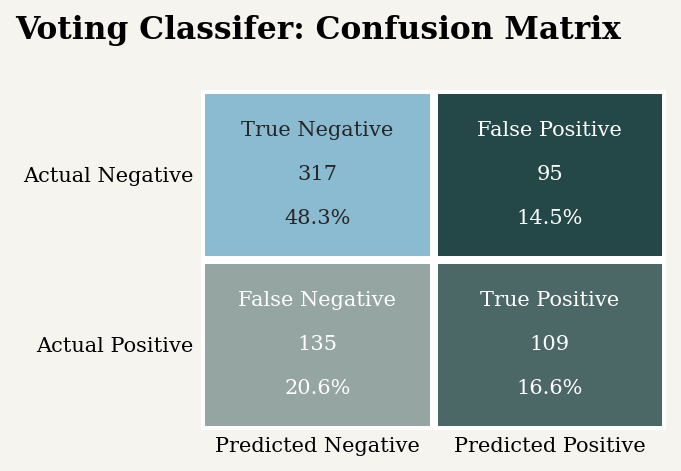

In [39]:
fig, ax = plt.subplots(1,1, figsize=(4,3), facecolor=background_color)

confusion = confusion_matrix(y_test, predictions)
    
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in confusion.flatten()]
group_percentages = ['{0:.1%}'.format(value) for value in confusion.flatten()/np.sum(confusion)]
labels = [f'{v1}\n\n{v2}\n\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confusion, annot=labels, fmt='', cmap=colormap, linewidth=3, cbar=False,
           xticklabels=['Predicted Negative','Predicted Positive'],
           yticklabels=['Actual Negative', 'Actual Positive'], ax=ax)

ax.tick_params(which='both', axis='both', length=0)
plt.yticks(rotation=0) 

ax.text(-0.8,-0.3,'Voting Classifer: Confusion Matrix',fontsize=15, fontweight='bold')

plt.show()

As we can see, the model performs well at predicting negatives, however it is poor at predicting positives.

**Importance of Error Metrics**

This, along with all the model performances above, really show the importance of defining your error metric. 

This is typically done by answering the questions: 

"**Why do I want to predict Variable X?**" 

or 

"**What does success look like?**"

Once you have thoses answers you can start to apply logic to your choice of error metric. For example, in this case one could reasonably argue that the worst case scenario would be for our model to have a high number of False Positives. If our model was to predict a water source was Potable, when in fact it was not, the unsuspecting drinker of the water could find themselves very ill. 

So in that respect, we might choose a model that is perhaps more cautious in predicting Positive ('Potable' in our case) classifications.

# **Model Improvement**

The next steps in this notebook are to fine tune the models. This will likely improve our scores.

I could possibily look to remove outliers in the dataset, too.

Also, it might be worth trialling SMOTE to resmaple our data.

***Work in progress***